#Course 04

##Week 04

###Real Life Problems:

In [0]:
!pip install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 37kB/s 
     |████████████████████████████████| 3.1MB 76.1MB/s 
     |████████████████████████████████| 501kB 79.3MB/s 
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.0.0-beta0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [0]:
time = np.arange(4 * 365 + 1, dtype="float32") #this is the x axis for our data 

baseline = 10 #for teh series creation overall 
slope = 0.05  #for trend function 

amplitude = 40 

noise_level = 5 #this is for the noise creation 

# Create the series

series = baseline +\
         trend(time, slope) +\
         seasonality(time, period=365, amplitude=amplitude)+\
         noise(time, noise_level, seed=42)

In [0]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
''' 
Xs = [1,2,3,4,5,6,7,,8,9,10]

window_size = 4
batch_size = 3

Ys  =  [ [ 
           [1,2,3,4][5] ,
           [2,3,4,5][6] ,
           [3,4,5,6][7]   
         ],
         [ [4,5,6,7][8] , 
           [5,6,7,8][9] , 
           [6,7,8,9][10]  
         ]    
       ]
'''

print(' ')

In [0]:
# here we first need to take care of the dimestion as in the model we will not have the Lambda Layer any more 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  
  series = tf.expand_dims(series , axis = -1 )
  
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  
  return dataset

In [0]:
# lets write a function for the model forecast rather than the individual calls :

def model_forecast(model, series , window_size ):

  mydata = tf.data.Dataset.from_tensor_slices(series)
  mydata = mydata.window(window_size , shift = 1 , drop_remainder = True)
  mydata = mydata.flat_map(lambda window : window.batch(window_size))
  mydata = mydata.batch(32).prefetch(1)
  forecast = model.predict(mydata)

  return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
window_size = 30
batch_size = 128
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32 , kernel_size = 5 ,
                         strides = 1 , padding = 'causal',
                         activation = 'relu',
                         input_shape = [None,1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

Now that we have specified the shape in the Convolution Layer of the Model we nned to modify the windowed_data function :

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [0]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),
              metrics=["mae"])

In [0]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 426ms/step - loss: 73.7833 - mae: 74.1150
Epoch 2/100
8/8 [==============================] - 1s 67ms/step - loss: 73.0351 - mae: 73.3971
Epoch 3/100
8/8 [==============================] - 1s 64ms/step - loss: 71.8754 - mae: 72.2451
Epoch 4/100
8/8 [==============================] - 1s 63ms/step - loss: 70.4263 - mae: 70.8026
Epoch 5/100
8/8 [==============================] - 0s 62ms/step - loss: 68.7344 - mae: 69.1172
Epoch 6/100
8/8 [==============================] - 1s 64ms/step - loss: 66.8004 - mae: 67.1908
Epoch 7/100
8/8 [==============================] - 1s 63ms/step - loss: 64.6024 - mae: 65.0022
Epoch 8/100
8/8 [==============================] - 1s 64ms/step - loss: 62.0938 - mae: 62.5067
Epoch 9/100
8/8 [==============================] - 0s 62ms/step - loss: 59.2056 - mae: 59.6389
Epoch 10/100
8/8 [==============================] - 0s 61ms/step - loss: 55.8366 - mae: 56.3058
Epoch 11/100
8/8 [==============================

(1e-08, 0.0001, 0.0, 30.0)

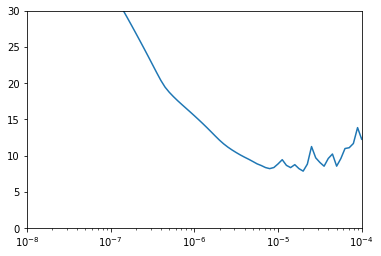

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

window_size = 30
batch_size = 128
shuffle_buffer_size = 1000

#create the train data
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#create the model :
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32 , kernel_size = 5,
                         strides = 1 , padding = 'causal',
                         activation = 'relu',
                         input_shape=[None,1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

#Compile the model ;
model.compile(loss = tf.keras.losses.Huber(), 
              optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),
              metrics=["mae"])

#Train the Model :
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
8/8 [==============================] - 3s 421ms/step - loss: 47.8501 - mae: 48.8041
Epoch 2/500
8/8 [==============================] - 0s 62ms/step - loss: 26.6298 - mae: 27.4308
Epoch 3/500
8/8 [==============================] - 1s 63ms/step - loss: 17.1482 - mae: 17.6485
Epoch 4/500
8/8 [==============================] - 1s 66ms/step - loss: 14.0402 - mae: 14.5277
Epoch 5/500
8/8 [==============================] - 1s 65ms/step - loss: 11.5962 - mae: 12.0606
Epoch 6/500
8/8 [==============================] - 0s 61ms/step - loss: 10.3063 - mae: 10.7513
Epoch 7/500
8/8 [==============================] - 0s 62ms/step - loss: 9.5450 - mae: 9.9843
Epoch 8/500
8/8 [==============================] - 1s 63ms/step - loss: 8.8979 - mae: 9.3356
Epoch 9/500
8/8 [==============================] - 1s 64ms/step - loss: 8.4129 - mae: 8.8502
Epoch 10/500
8/8 [==============================] - 1s 63ms/step - loss: 8.1100 - mae: 8.5444
Epoch 11/500
8/8 [==============================] - 1s 6

In [0]:
rnn_forecast = model_forecast(model , series[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0]

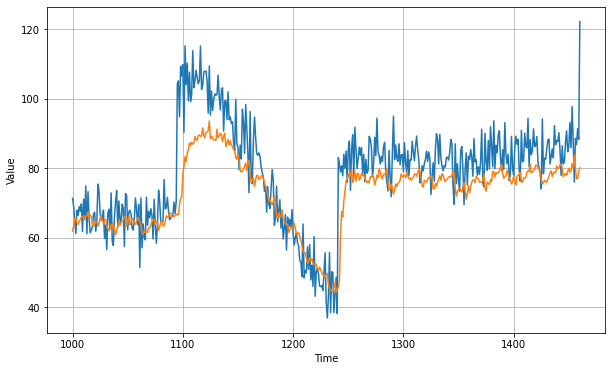

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.3544884

<Figure size 432x288 with 0 Axes>

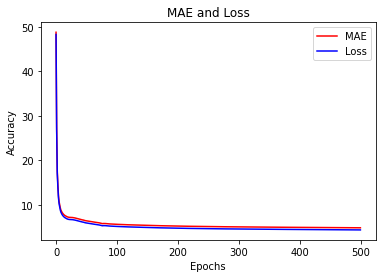

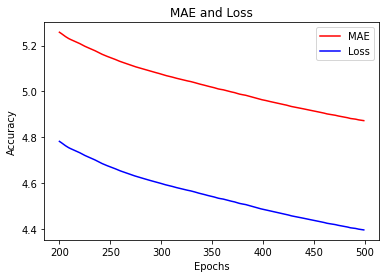

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

###SunSpots Problem :

In [0]:
!pip install tensorflow==2.0.0-beta0

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
print(tf.__version__)

2.0.0-beta0


Function for Plotting the Data:

In [0]:
def plot_series(x,y,format = '-',start = 0 , end = None):
  plt.plot(x[start:end],y[start:end],format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

Download the Data :

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

Read the Data :

Shape of data_X : 3235
Shape of the Data_Y is : 3235


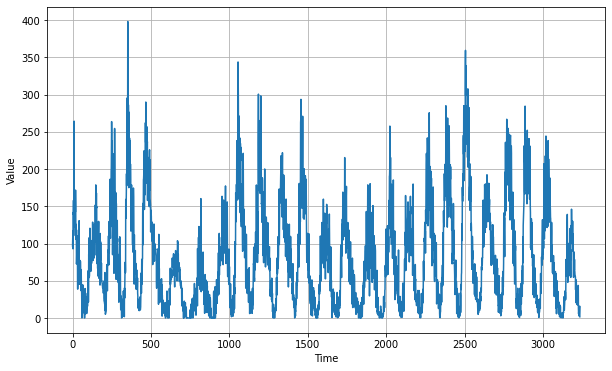

In [0]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile,delimiter = ',')
  #skip the first row as it is the column names 
  next(reader)
  for row in reader:
    #type cast before appending the data
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

#check the shape of teh data read:
print(f'Shape of data_X : {len(sunspots)}')
print(f'Shape of the Data_Y is : {len(time_step)}')

#Now the data is in a list format 
#Lets convert into numpy array for convineance

series = np.array(sunspots)
time = np.array(time_step)


#Now lwts plot the data read :
plt.figure(figsize = (10,6))
plot_series(time,series)

Train Test Split :

In [0]:
split_time = 3000

time_train = time[ : split_time]
x_train = series[ : split_time]

time_valid = time[split_time : ]
x_valid = series[split_time : ]

In [0]:
print(type(x_train))
print(x_train.shape)

<class 'numpy.ndarray'>
(3000,)


Define some parameters: You can play with these to improve the Model Accuracy:

In [0]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

Now lwts define the function to convert the series into Xs and Ys:

In [0]:
# input = Numpay array called series 
# Output = dataset  with Xs and Ys bundled in batches :

''' 
Xs = [1,2,3,4,5,6,7,,8,9,10]

window_size = 4
batch_size = 3

Ys  =  [ [ 
           [1,2,3,4][5] ,
           [2,3,4,5][6] ,
           [3,4,5,6][7]   
         ],
         [ [4,5,6,7][8] , 
           [5,6,7,8][9] , 
           [6,7,8,9][10]  
         ]    
       ]
'''
def windowed_dataset(series , window_size , batch_size ,shuffle_buffer_size):
  series = np.expand_dims(series , axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  dataset = ds.window(window_size + 1, shift = 1 , drop_remainder = True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window :(window[:-1],window[:-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Now lets create the dataset and Model and compile nad fit :

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train , window_size = 60,batch_size = 32, shuffle_buffer_size = 1000)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                               padding = 'causal',strides = 1,
                               activation = 'relu',
                               input_shape= [None,1]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Dense(20,activation = 'relu'),
       tf.keras.layers.Dense(10 , activation = 'relu'),
       tf.keras.layers.Dense(1),
       tf.keras.layers.Lambda(lambda x:x*400)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda x :1e-8 * 10**(x/20))

model.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-8,momentum = 0.9),
              loss = tf.keras.losses.Huber(),
              metrics = ['mae'])


history = model.fit(train_set,epochs = 100 , callbacks = [lr_schedule])



Epoch 1/100
92/92 [==============================] - 12s 127ms/step - loss: 194.0902 - mae: 194.5974
Epoch 2/100
92/92 [==============================] - 8s 83ms/step - loss: 134.4065 - mae: 134.9307
Epoch 3/100
92/92 [==============================] - 8s 85ms/step - loss: 84.9277 - mae: 85.4330
Epoch 4/100
92/92 [==============================] - 8s 84ms/step - loss: 58.9969 - mae: 59.4945
Epoch 5/100
92/92 [==============================] - 8s 82ms/step - loss: 45.8833 - mae: 46.3772
Epoch 6/100
92/92 [==============================] - 7s 79ms/step - loss: 40.4815 - mae: 40.9751
Epoch 7/100
92/92 [==============================] - 7s 81ms/step - loss: 38.1124 - mae: 38.6059
Epoch 8/100
92/92 [==============================] - 7s 81ms/step - loss: 36.5875 - mae: 37.0813
Epoch 9/100
92/92 [==============================] - 7s 81ms/step - loss: 35.2610 - mae: 35.7549
Epoch 10/100
92/92 [==============================] - 7s 81ms/step - loss: 33.9845 - mae: 34.4784
Epoch 11/100
92/92 [===

Lets now plot the loss vs lr so that we get to select the best learning rate :

(1e-08, 0.0001, 0.0, 60.0)

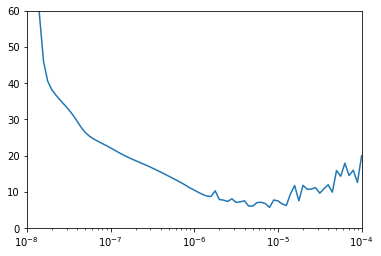

In [0]:
plt.semilogx(history.history['lr'] ,history.history['loss'])
plt.axis([1e-8,1e-4,0,60])

Now that we know the best learnig rate,lets train the model with that learning rate for more number of epochs:

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train , window_size = 60 , batch_size = 16 , shuffle_buffer_size = 1000)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                               padding = 'causal',strides = 1,
                               activation = 'relu',
                               input_shape= [None,1]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Dense(20,activation = 'relu'),
       tf.keras.layers.Dense(10 , activation = 'relu'),
       tf.keras.layers.Dense(1),
       tf.keras.layers.Lambda(lambda x:x*400)
])



model.compile(optimizer = tf.keras.optimizers.SGD(lr = 2e-5,momentum = 0.9),
              loss = tf.keras.losses.Huber(),
              metrics = ['mae'])


history = model.fit(train_set,epochs = 100 )

Epoch 1/100
92/92 [==============================] - 12s 128ms/step - loss: 26.2528 - mae: 26.7554
Epoch 2/100
92/92 [==============================] - 7s 81ms/step - loss: 17.1913 - mae: 17.6794
Epoch 3/100
92/92 [==============================] - 7s 81ms/step - loss: 14.7749 - mae: 15.2627
Epoch 4/100
92/92 [==============================] - 7s 81ms/step - loss: 11.3474 - mae: 11.8389
Epoch 5/100
92/92 [==============================] - 7s 80ms/step - loss: 8.3612 - mae: 8.8441
Epoch 6/100
92/92 [==============================] - 8s 82ms/step - loss: 7.4888 - mae: 7.9686
Epoch 7/100
92/92 [==============================] - 8s 82ms/step - loss: 8.1176 - mae: 8.5993
Epoch 8/100
92/92 [==============================] - 7s 81ms/step - loss: 5.6267 - mae: 6.1039
Epoch 9/100
92/92 [==============================] - 7s 81ms/step - loss: 7.9682 - mae: 8.4509
Epoch 10/100
92/92 [==============================] - 7s 81ms/step - loss: 8.0512 - mae: 8.5356
Epoch 11/100
92/92 [===================

Now lets make the model predict :

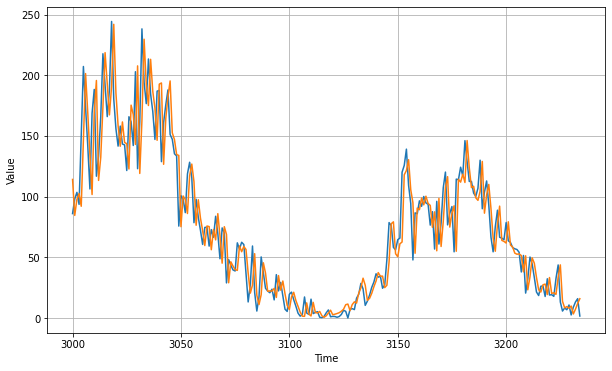

Model Error on Predicted Values :  16.189394


In [0]:
def model_forecast(model, series , window_size ):

  mydata = tf.data.Dataset.from_tensor_slices(series)
  mydata = mydata.window(window_size , shift = 1 , drop_remainder = True)
  mydata = mydata.flat_map(lambda window : window.batch(window_size))
  mydata = mydata.batch(32).prefetch(1)
  forecast = model.predict(mydata)

  return forecast

rnn_forecast = model_forecast(model , series[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

print("Model Error on Predicted Values : ",tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

### Excercise - 04 : Sunspots


Exercise 4 - Sunspots

This week you moved away from synthetic data to do a real-world prediction -- sunspots. You loaded data from CSV and built models to use it. For this week’s exercise, you’ll use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to download the dataset, parse the CSV, create a time series and build a prediction model from it. Your model should have an MAE of less than 2, and as you can see in the output, mine had 1.78. I’m sure you can beat that! :)

In [0]:
!pip install tensorflow==2.0.0-beta0

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-28 10:54:16--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-04-28 10:54:16 (2.59 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



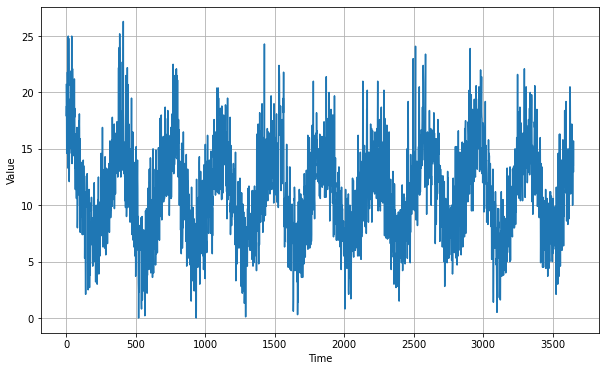

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)
  i = 1 

  for rows in reader:
    time_step.append(i)
    i = i + 1
    temps.append(float(rows[1]))

# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500

time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE

time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = np.expand_dims(series , axis = -1)

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1 , shift = 1 , drop_remainder = True)
  dataset = dataset.flat_map(lambda x :  x.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda x : (x[:-1],x[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
    # YOUR CODE HERE

In [0]:
def model_forecast(model, series, window_size):

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size , shift = 1 , drop_remainder = True)
  dataset = dataset.flat_map(lambda x :  x.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  predicted = model.predict(dataset)
  return predicted

    # YOUR CODE HERE

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
       tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                               padding = 'causal',strides = 1,
                               activation = 'relu',
                               input_shape= [None,1]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Dense(20,activation = 'relu'),
       tf.keras.layers.Dense(10 , activation = 'relu'),
       tf.keras.layers.Dense(1),
       tf.keras.layers.Lambda(lambda x:x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/200
10/10 [==============================] - 7s 719ms/step - loss: 42.1369 - mae: 42.6199
Epoch 2/200
10/10 [==============================] - 3s 292ms/step - loss: 41.9548 - mae: 42.4417
Epoch 3/200
10/10 [==============================] - 3s 286ms/step - loss: 41.6815 - mae: 42.1699
Epoch 4/200
10/10 [==============================] - 3s 284ms/step - loss: 41.3509 - mae: 41.8405
Epoch 5/200
10/10 [==============================] - 3s 283ms/step - loss: 40.9727 - mae: 41.4636
Epoch 6/200
10/10 [==============================] - 3s 285ms/step - loss: 40.5476 - mae: 41.0398
Epoch 7/200
10/10 [==============================] - 3s 285ms/step - loss: 40.0742 - mae: 40.5678
Epoch 8/200
10/10 [==============================] - 3s 290ms/step - loss: 39.5500 - mae: 40.0452
Epoch 9/200
10/10 [==============================] - 3s 286ms/step - loss: 38.9739 - mae: 39.4706
Epoch 10/200
10/

(1e-08, 0.0001, 0.0, 20.0)

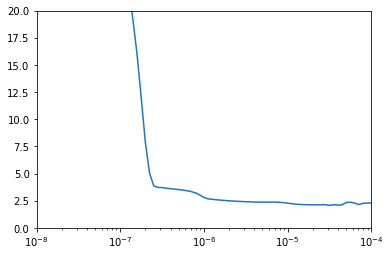

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0,20])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size = 60, batch_size = 100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
      tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                               padding = 'causal',strides = 1,
                               activation = 'relu',
                               input_shape= [None,1]),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
       tf.keras.layers.Dense(20,activation = 'relu'),
       tf.keras.layers.Dense(10 , activation = 'relu'),
       tf.keras.layers.Dense(1),
       tf.keras.layers.Lambda(lambda x:x*100)
])


optimizer = tf.keras.optimizers.SGD(lr= 3.98e-05 ,momentum = 0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)# YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/200
25/25 [==============================] - 8s 302ms/step - loss: 9.2192 - mae: 9.8649
Epoch 2/200
25/25 [==============================] - 3s 127ms/step - loss: 2.5074 - mae: 2.9736
Epoch 3/200
25/25 [==============================] - 3s 127ms/step - loss: 2.2094 - mae: 2.6665
Epoch 4/200
25/25 [==============================] - 3s 129ms/step - loss: 2.2056 - mae: 2.6637
Epoch 5/200
25/25 [==============================] - 3s 128ms/step - loss: 2.1911 - mae: 2.6486
Epoch 6/200
25/25 [==============================] - 3s 126ms/step - loss: 2.1813 - mae: 2.6385
Epoch 7/200
25/25 [==============================] - 3s 127ms/step - loss: 2.1728 - mae: 2.6299
Epoch 8/200
25/25 [==============================] - 3s 128ms/step - loss: 2.1554 - mae: 2.6126
Epoch 9/200
25/25 [==============================] - 3s 126ms/step - loss: 2.1571 - mae: 2.6117
Epoch 10/200
25/25 [==============================] - 3s 127ms/step - loss: 2.1770 - mae: 2.6347
Epoch 11/200
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

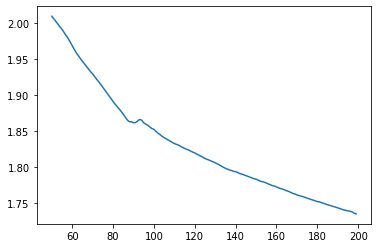

In [0]:
epochs = np.arange(len(history.history["loss"]))
plt.plot(epochs[50:], history.history["loss"][50:])
plt.show()

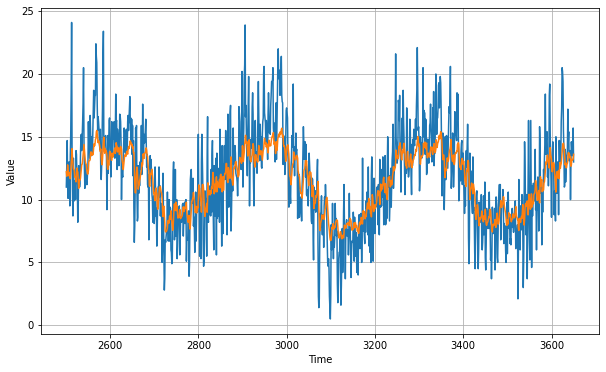

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.0173368

In [0]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.210557 11.862871 12.142491 ... 13.173896 13.235853 13.605388]
